## COMP3340 Group 9 - PPO - MLP

In [1]:
# change to False if you want to retrain the agent
NO_TRAINING = True
# NO_TRAINING = False

### Dependencies

In [2]:
# !pip install DI-engine
# !pip install gym==0.25.1

In [3]:
import warnings

CONFIG_PATH = "LunarLander-v2-PPO-MLP"

### Train

In [4]:
warnings.filterwarnings('ignore')

from ding.bonus import PPOF
from ding.framework import OnlineRLContext, task
from ding.framework.middleware import (
    interaction_evaluator_ttorch, PPOFStepCollector, multistep_trainer, CkptSaver,
    termination_checker, ppof_adv_estimator
)

from ding.envs import DingEnvWrapper, BaseEnvManagerV2
import gym

from typing import Optional

class PPOFAgent(PPOF):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def train(
        self,
        step: int = int(1e7),
        collector_env_num: int = 4,
        evaluator_env_num: int = 4,
        n_iter_log_show: int = 500,
        n_iter_save_ckpt: int = 1000,
    ) -> None:
        """
        Adapted from original implementation removing unccessary codes and added global flow control:
        https://github.com/opendilab/DI-engine/blob/main/ding/bonus/ppof.py#L199
        """
        if NO_TRAINING: return

        manager_cfg = BaseEnvManagerV2.default_config()

        collector_env = BaseEnvManagerV2(
            env_fn=[lambda: DingEnvWrapper(gym.make("LunarLander-v2")) for _ in range(collector_env_num)],
            cfg=manager_cfg
        )

        evaluator_env = BaseEnvManagerV2(
            env_fn=[lambda: DingEnvWrapper(gym.make("LunarLander-v2")) for _ in range(evaluator_env_num)],
            cfg=manager_cfg
        )

        with task.start(ctx=OnlineRLContext()):
            task.use(interaction_evaluator_ttorch(self.seed, self.policy, evaluator_env))
            task.use(CkptSaver(self.policy, save_dir=self.checkpoint_save_dir, train_freq=n_iter_save_ckpt))
            task.use(PPOFStepCollector(self.seed, self.policy, collector_env, self.cfg.n_sample))
            task.use(ppof_adv_estimator(self.policy))
            task.use(multistep_trainer(self.policy, log_freq=n_iter_log_show))
            task.use(termination_checker(max_env_step=step))
            task.run()

[04-24 23:57:10] WARNING  not found transformer, please install it using: pip install transformers                                               ]8;id=577364;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\model\template\language_transformer.py\language_transformer.py]8;;\:]8;id=610966;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\model\template\language_transformer.py#9\9]8;;\

In [5]:
from ding.bonus.config import get_instance_config

cfg = get_instance_config("LunarLander-v2", "PPOF")
display(cfg)

{'type': 'ppo',
 'on_policy': True,
 'cuda': True,
 'action_space': 'discrete',
 'discount_factor': 0.99,
 'gae_lambda': 0.95,
 'epoch_per_collect': 10,
 'batch_size': 64,
 'learning_rate': 0.0003,
 'lr_scheduler': None,
 'weight_decay': 0,
 'value_weight': 0.5,
 'entropy_weight': 0.001,
 'clip_ratio': 0.2,
 'adv_norm': True,
 'value_norm': 'popart',
 'ppo_param_init': True,
 'grad_norm': 0.5,
 'n_sample': 512,
 'unroll_len': 1,
 'deterministic_eval': True,
 'model': {},
 'cfg_type': 'PPOFPolicyDict'}

In [6]:
import logging

LOG_FILE_PATH = f"{CONFIG_PATH}/log/train/training.log"

logger = logging.getLogger()
handler = logging.FileHandler(LOG_FILE_PATH)
logger.addHandler(handler)

In [7]:
from ding.utils import save_file

warnings.filterwarnings('ignore')

COLLECTOR_NUM = 4
EVALUATOR_NUM = 4
MANUAL_CKPT = f"{CONFIG_PATH}/ckpt/manual_final.pth.tar"

agent = PPOFAgent(env_id="LunarLander-v2", exp_name=CONFIG_PATH, cfg=cfg)
agent.train(
    step=int(4000000), 
    collector_env_num=COLLECTOR_NUM, 
    evaluator_env_num=EVALUATOR_NUM,
)

if not NO_TRAINING: 
    save_file(MANUAL_CKPT, agent.policy.learn_mode.state_dict())

logger.removeHandler(handler)

### Plot History
The package does not store the training loss history locally, so it is needed to use the log output to extract the history.

In [8]:
loss_hist = []
eval_rewards = []

strip_fn = lambda x, name: x.removeprefix(f"{name}(").removesuffix(")")

with open(LOG_FILE_PATH, "r") as f:
    for line in f.readlines():
        line = line.lower().split()
        if line[0].startswith('['): line = line[3:-1]

        if line[0] != "training:" and line[0] != "evaluation:": continue

        iter = int(strip_fn(line[2], "iter"))
        step = int(strip_fn(line[4], "step"))
        
        if line[0] == "training:":
            loss = float(strip_fn(line[-1], "loss"))
            loss_hist.append([iter, step, loss])

        elif line[0] == "evaluation:":
            reward = float(strip_fn(line[-1], "return"))
            eval_rewards.append([iter, step, reward])

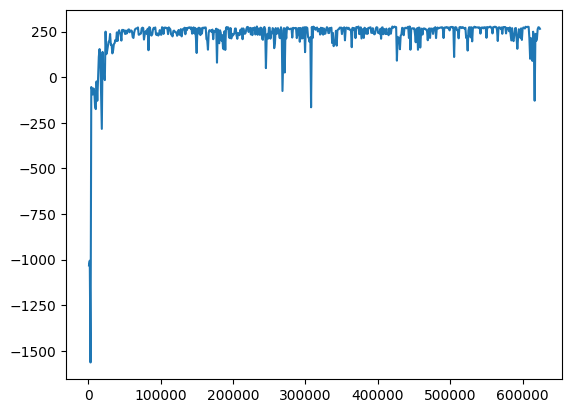

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

loss_hist = np.asarray(loss_hist)
eval_rewards = np.asarray(eval_rewards)

df = pd.DataFrame(data=eval_rewards, columns=["iter", "step", "reward"])
df.to_csv(f"{LOG_FILE_PATH.split('.')[0]}.csv")

plt.plot(eval_rewards[:, 0], eval_rewards[:, -1])

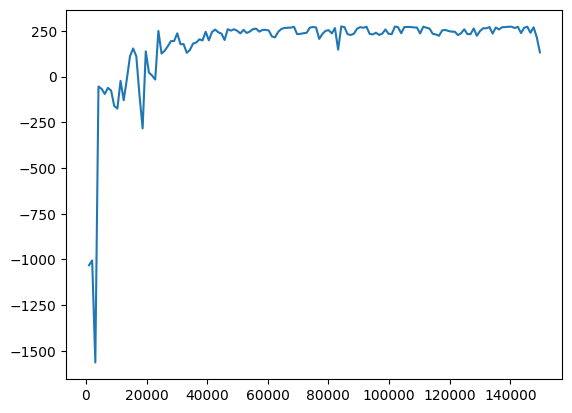

In [10]:
cutoff = eval_rewards[:, 0] < 1.5e5

plt.plot(eval_rewards[:, 0][cutoff], eval_rewards[:, -1][cutoff])

### Result

Remarks: Although the log is printing **"DQN"**, the agent is still trained using **PPO**. This is because the code for the logging part in the package is hardcoded.

In [11]:
from easydict import EasyDict
from random import randint
import torch

warnings.filterwarnings('ignore')

env = DingEnvWrapper(gym.make("LunarLander-v2"), EasyDict(env_wrapper='default'))
eval_agent = PPOFAgent(env_id="LunarLander-v2", exp_name="LunarLander-v2-PPO-MLP", cfg=cfg)
eval_agent.policy.eval_mode.load_state_dict(torch.load(MANUAL_CKPT))

eval_agent.deploy(True, seed=[randint(0, 1e9) for _ in range(20)])

[04-24 23:57:23] INFO     DQN deploy is finished, final episode return with 93 steps is: [51.770752]                                                           ]8;id=648406;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=838234;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:24] INFO     DQN deploy is finished, final episode return with 169 steps is: [263.3382]                                                           ]8;id=849574;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=631140;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:26] INFO     DQN deploy is finished, final episode return with 271 steps is: [301.83304]                                                          ]8;id=765284;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=77324;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:27] INFO     DQN deploy is finished, final episode return with 172 steps is: [280.77966]                                                          ]8;id=495077;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=587007;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:33] INFO     DQN deploy is finished, final episode return with 1000 steps is: [165.29247]                                                         ]8;id=640561;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=671532;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:34] INFO     DQN deploy is finished, final episode return with 190 steps is: [281.6443]                                                           ]8;id=464197;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=907343;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:35] INFO     DQN deploy is finished, final episode return with 190 steps is: [261.96466]                                                          ]8;id=963080;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=575352;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:36] INFO     DQN deploy is finished, final episode return with 170 steps is: [257.0539]                                                           ]8;id=880899;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=418196;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:38] INFO     DQN deploy is finished, final episode return with 175 steps is: [274.34772]                                                          ]8;id=655638;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=1198;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:39] INFO     DQN deploy is finished, final episode return with 155 steps is: [261.54608]                                                          ]8;id=349317;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=255759;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:40] INFO     DQN deploy is finished, final episode return with 215 steps is: [302.19153]                                                          ]8;id=66043;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=200348;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:41] INFO     DQN deploy is finished, final episode return with 169 steps is: [296.4864]                                                           ]8;id=842368;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=149416;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:42] INFO     DQN deploy is finished, final episode return with 165 steps is: [273.77533]                                                          ]8;id=84353;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=335601;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:44] INFO     DQN deploy is finished, final episode return with 134 steps is: [45.218613]                                                          ]8;id=114355;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=316089;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:45] INFO     DQN deploy is finished, final episode return with 196 steps is: [304.19318]                                                          ]8;id=574033;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=348914;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:46] INFO     DQN deploy is finished, final episode return with 187 steps is: [262.693]                                                            ]8;id=838260;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=632485;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:47] INFO     DQN deploy is finished, final episode return with 180 steps is: [272.29636]                                                          ]8;id=96083;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=625252;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:48] INFO     DQN deploy is finished, final episode return with 167 steps is: [265.2151]                                                           ]8;id=253867;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=304432;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:50] INFO     DQN deploy is finished, final episode return with 192 steps is: [249.39899]                                                          ]8;id=34574;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=642539;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

[04-24 23:57:51] INFO     DQN deploy is finished, final episode return with 209 steps is: [287.61078]                                                          ]8;id=94187;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py\ppof.py]8;;\:]8;id=711693;file://c:\Users\User\.conda\envs\ppo\lib\site-packages\ding\bonus\ppof.py#344\344]8;;\

EvalReturn(eval_value=247.93246, eval_value_std=72.36859)